# GPyTorch Classification Tutorial
## Introduction

This example is the simplest form of using an RBF kernel in an `VariationalGP` module for classification. This basic model is usable when there is not much training data and no advanced techniques are required.

In this example, we’re modeling a unit wave with period 1/2 centered with positive values @ x=0. We are going to classify the points as either +1 or -1.

Variational inference uses the assumption that the posterior distribution factors multiplicatively over the input variables. This makes approximating the distribution via the KL divergence possible to obtain a fast approximation to the posterior. For a good explanation of variational techniques, sections 4-6 of the following may be useful: https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf

In [1]:
import math
import torch
import gpytorch
import pyro
from matplotlib import pyplot as plt

%matplotlib inline

### Set up training data

In the next cell, we set up the training data for this example. We'll be using 15 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels. Labels are unit wave with period 1/2 centered with positive values @ x=0.

In [2]:
train_x = torch.linspace(0, 1, 10)
train_y = torch.sign(torch.cos(train_x * (4 * math.pi)))
#train_y[train_y == -1] = 0

## Setting up the classification model

The next cell demonstrates the simplist way to define a classification Gaussian process model in GPyTorch. If you have already done the [GP regression tutorial](../01_Simple_GP_Regression/Simple_GP_Regression.ipynb), you have already seen how GPyTorch model construction differs from other GP packages. In particular, the GP model expects a user to write out a `forward` method in a way analogous to PyTorch models. This gives the user the most possible flexibility.

Since exact inference is intractable for GP classification, GPyTorch approximates the classification posterior using **variational inference.** We believe that variational inference is ideal for a number of reasons. Firstly, variational inference commonly relies on gradient descent techniques, which take full advantage of PyTorch's autograd. This reduces the amount of code needed to develop complex variational models. Additionally, variational inference can be performed with stochastic gradient decent, which can be extremely scalable for large datasets.

If you are unfamiliar with variational inference, we recommend the following resources:
- [Variational Inference: A Review for Statisticians](https://arxiv.org/abs/1601.00670) by David M. Blei, Alp Kucukelbir, Jon D. McAuliffe.
- [Scalable Variational Gaussian Process Classification](https://arxiv.org/abs/1411.2005) by James Hensman, Alex Matthews, Zoubin Ghahramani.

### The necessary casses

For most GP regression models, you will need to construct the following GPyTorch objects:

1. A **GP Model** (`gpytorch.models.VariationalGP`) -  This handles basic variational inference.
1. A **Likelihood** (`gpytorch.likelihoods.BernoulliLikelihood`) - This is a good likelihood for binary classification
1. A **Mean** - This defines the prior mean of the GP.
  - If you don't know which mean to use, a `gpytorch.means.ConstantMean()` is a good place to start.
1. A **Kernel** - This defines the prior covariance of the GP.
  - If you don't know which kernel to use, a `gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())` is a good place to start.
1. A **MultivariateNormal** Distribution (`gpytorch.distributions.MultivariateNormal`) - This is the object used to represent multivariate normal distributions.
  
  
#### The GP Model
  
The `VariationalGP` model is GPyTorch's simplist approximate inference model. It approximates the true posterior with a multivariate normal distribution. The model defines all the variational parameters that are needed, and keeps all of this information under the hood.

The components of a user built `VariationalGP` model in GPyTorch are:

1. An `__init__` method that takes the training data as an input. The `__init__` function will also construct a mean module, a kernel module, and whatever other modules might be necessary.

2. A `forward` method that takes in some $n \times d$ data `x` and returns a MultivariateNormal with the *prior* mean and covariance evaluated at `x`. In other words, we return the vector $\mu(x)$ and the $n \times n$ matrix $K_{xx}$ representing the prior mean and covariance matrix of the GP.

(For those who are unfamiliar with GP classification: even though we are performing classification, the GP model still returns a `MultivariateNormal`. The likelihood transforms this latent Gaussian variable into a Bernoulli variable)

Here we present a simple classification model, but it is posslbe to construct more complex models. See some of the [scalable classification examples](../07_Scalable_GP_Classification_Multidimensional/) or [deep kernel learning examples](../08_Deep_Kernel_Learning) for some other examples.

In [3]:
from gpytorch.lazy import NonLazyTensor

class DefaultVariationalMarginalizationStrategy(object):
    def __init__(self, model):
        self.model = model
    
    @property
    def inducing_points(self):
        return self.model.inducing_points
    
    def marginalize(self, x, variational_dist):
        if torch.equal(x, self.inducing_points):
            return variational_dist, self.model(x)
        else:
            n_induc = len(self.inducing_points)
            full_inputs = torch.cat([self.inducing_points, x])
            full_output = self.model(full_inputs)
            full_mean, full_covar = full_output.mean, full_output.lazy_covariance_matrix
            
            induc_mean = full_mean[:n_induc]
            induc_induc_covar = full_covar[:n_induc, :n_induc]
            
            induc_data_covar = full_covar[:n_induc, n_induc:].evaluate()
            data_data_covar = full_covar[n_induc:, n_induc:]
            
            interpolation_matrix = (induc_induc_covar.inv_matmul(induc_data_covar)).transpose(-1, -2)
            predictive_mean = interpolation_matrix @ variational_dist.mean
            predictive_covar = (
                gpytorch.lazy.RootLazyTensor(interpolation_matrix @ variational_dist.scale_tril) +
                data_data_covar + gpytorch.lazy.MatmulLazyTensor(interpolation_matrix, induc_data_covar).mul(-1)
            )
            
            return (gpytorch.distributions.MultivariateNormal(predictive_mean, predictive_covar), gpytorch.distributions.MultivariateNormal(induc_mean, induc_induc_covar))
        

class DefaultVariationalDistributionStrategy(object):
    def __init__(self, model):
        self.model = model
        initial_dist = model(self.inducing_points)
        initial_mean = torch.randn_like(initial_dist.mean)
        prior_covar = NonLazyTensor(initial_dist.covariance_matrix).add_jitter().evaluate()
        initial_covar = gpytorch.utils.cholesky.batch_potrf(prior_covar)
    
        model.register_parameter(name="variational_mean",
                                 parameter=torch.nn.Parameter(initial_mean))
        model.register_parameter(name="chol_variational_covar",
                                 parameter=torch.nn.Parameter(initial_covar))
    
    @property
    def inducing_points(self):
        return self.model.inducing_points
        
    @property
    def variational_distribution(self):
        chol_variational_covar = self.model.chol_variational_covar
        if chol_variational_covar.ndimension() == 2:
            chol_variational_covar = chol_variational_covar.triu()
            inside = chol_variational_covar.diag().sign().unsqueeze(1).expand_as(chol_variational_covar).triu()
        elif chol_variational_covar.ndimension() == 3:
            batch_size, diag_size, _ = chol_variational_covar.size()

            # Batch mode
            chol_variational_covar_size = list(chol_variational_covar.size())[-2:]
            mask = torch.ones(
                *chol_variational_covar_size, dtype=chol_variational_covar.dtype, device=chol_variational_covar.device
            ).triu_()
            mask = mask.unsqueeze(0).expand(*([chol_variational_covar.size(0)] + chol_variational_covar_size))

            batch_index = torch.arange(0, batch_size, dtype=torch.long, device=mask.device)
            batch_index = batch_index.unsqueeze(1).repeat(1, diag_size).view(-1)
            diag_index = torch.arange(0, diag_size, dtype=torch.long, device=mask.device)
            diag_index = diag_index.unsqueeze(1).repeat(batch_size, 1).view(-1)
            diag = chol_variational_covar[batch_index, diag_index, diag_index].view(batch_size, diag_size)

            chol_variational_covar = chol_variational_covar.mul(mask)
            inside = diag.sign().unsqueeze(-1).expand_as(chol_variational_covar).mul(mask)
        else:
            raise RuntimeError("Invalid number of variational covar dimensions")

        self.model.chol_variational_covar.data = inside.mul(chol_variational_covar)
        return pyro.distributions.MultivariateNormal(self.model.variational_mean,
                                                      scale_tril=self.model.chol_variational_covar.transpose(-2, -1))


class PyroGPClassificationModel(gpytorch.Module):
    def __init__(self, likelihood, inducing_points):
        super(PyroGPClassificationModel, self).__init__()
        self.likelihood = likelihood
        self.inducing_points = inducing_points
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.dist_strategy = DefaultVariationalDistributionStrategy(self)
        self.marginal_strategy = DefaultVariationalMarginalizationStrategy(self)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x).add_jitter()
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred
    
    def guide(self, x, y):
        variational_dist = self.dist_strategy.variational_distribution
        pyro.sample("__inducing_values", variational_dist)
    
    def model(self, x, y):
        pyro.module("gp_prior", self)
        variational_dist = self.dist_strategy.variational_distribution
        variational_dist_f, prior_dist_induc = self.marginal_strategy.marginalize(x, variational_dist)
        pyro.sample("__inducing_values", prior_dist_induc)
        if prior_dist_induc is None:
            prior_dist_induc = self(self.inducing_points)
        #print(variational_dist_f.mean.data, variational_dist.mean.data)
        f_samples = variational_dist_f()
        y_prob_samples = torch.distributions.Normal(0, 1).cdf(f_samples)
        #print(f_samples.shape, f_samples)
        y_dist = pyro.distributions.Bernoulli(y_prob_samples)
        test = pyro.sample("__training_labels", y_dist, obs=y)
        print(test)
        
        
        

# Initialize model and likelihood
likelihood = gpytorch.likelihoods.BernoulliLikelihood()
model = PyroGPClassificationModel(likelihood, train_x)

In [4]:
from pyro import optim
from pyro import infer

optimizer = optim.Adam({"lr": 0.1})

elbo = infer.Trace_ELBO()
svi = infer.SVI(model.model, model.guide, optimizer, elbo)

In [5]:
for i in range(1000):
    svi.step(train_x, train_y)

tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.

tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.

tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.

tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.

tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.

tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.

tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.])
tensor([ 1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.

In [6]:
test_x = torch.linspace(0, 1, 30)
pred_dist, _ = model.marginal_strategy.marginalize(test_x, model.dist_strategy.variational_distribution)

In [7]:
model.variational_mean

Parameter containing:
tensor([ 1.8360,  1.3824, -4.2935, -5.3934,  0.7227,  0.0613, -4.9641, -2.3104,
         0.5094,  1.2540], requires_grad=True)

In [8]:
print(model.variational_mean, model.mean_module.constant)
print(pred_dist.mean)
pred_y = likelihood(pred_dist)

Parameter containing:
tensor([ 1.8360,  1.3824, -4.2935, -5.3934,  0.7227,  0.0613, -4.9641, -2.3104,
         0.5094,  1.2540], requires_grad=True) Parameter containing:
tensor([[-0.5767]], requires_grad=True)
tensor([ 1.8359,  2.2080,  2.2117,  1.6112,  0.3179, -1.5080, -3.4868, -5.1536,
        -6.0929, -6.0288, -4.9138, -3.0105, -0.8657,  0.8789,  1.7305,  1.4858,
         0.2462, -1.6095, -3.4880, -4.7563, -5.0205, -4.3208, -3.0634, -1.7405,
        -0.6670,  0.0902,  0.6092,  0.9722,  1.1962,  1.2539],
       grad_fn=<MvBackward>)


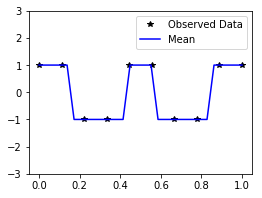

In [9]:
# Initialize fig and axes for plot
f, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
# Get the predicted labels (probabilites of belonging to the positive class)
# Transform these probabilities to be 0/1 labels
pred_labels = pred_y.mean.ge(0.5).float().mul(2).sub(1)
ax.plot(test_x.numpy(), pred_labels.numpy(), 'b')
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])

### Model modes

Like most PyTorch modules, the `ExactGP` has a `.train()` and `.eval()` mode.
- `.train()` mode is for optimizing variational parameters model hyperameters.
- `.eval()` mode is for computing predictions through the model posterior.

## Learn the variational parameters (and other hyperparameters)

In the next cell, we optimize the variational parameters of our Gaussian process.
In addition, this optimization loop also performs Type-II MLE to train the hyperparameters of the Gaussian process.

The most obvious difference here compared to many other GP implementations is that, as in standard PyTorch, the core training loop is written by the user. In GPyTorch, we make use of the standard PyTorch optimizers as from `torch.optim`, and all trainable parameters of the model should be of type `torch.nn.Parameter`. The variational parameters are predefined as part of the `VariationalGP` model.

In most cases, the boilerplate code below will work well. It has the same basic components as the standard PyTorch training loop:

1. Zero all parameter gradients
2. Call the model and compute the loss
3. Call backward on the loss to fill in gradients
4. Take a step on the optimizer

However, defining custom training loops allows for greater flexibility. For example, it is possible to learn the variational parameters and kernel hyperparameters with different learning rates.

In [4]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    # BernoulliLikelihood has no parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the amount of training data
mll = gpytorch.mlls.VariationalMarginalLogLikelihood(likelihood, model, num_data=len(train_y))

training_iter = 50
for i in range(training_iter):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (
        i + 1, training_iter, loss.item(),
    ))
    optimizer.step()

Iter 1/50 - Loss: 326.033
Iter 2/50 - Loss: 229.205
Iter 3/50 - Loss: 147.791
Iter 4/50 - Loss: 94.322
Iter 5/50 - Loss: 58.356
Iter 6/50 - Loss: 34.048
Iter 7/50 - Loss: 20.180
Iter 8/50 - Loss: 14.053
Iter 9/50 - Loss: 12.395
Iter 10/50 - Loss: 11.749
Iter 11/50 - Loss: 10.924
Iter 12/50 - Loss: 10.087
Iter 13/50 - Loss: 9.328
Iter 14/50 - Loss: 8.994
Iter 15/50 - Loss: 7.611
Iter 16/50 - Loss: 6.660
Iter 17/50 - Loss: 6.201
Iter 18/50 - Loss: 5.975
Iter 19/50 - Loss: 5.992
Iter 20/50 - Loss: 5.758
Iter 21/50 - Loss: 5.404
Iter 22/50 - Loss: 5.043
Iter 23/50 - Loss: 4.632
Iter 24/50 - Loss: 4.990
Iter 25/50 - Loss: 5.021
Iter 26/50 - Loss: 5.250
Iter 27/50 - Loss: 4.832
Iter 28/50 - Loss: 4.951
Iter 29/50 - Loss: 5.426
Iter 30/50 - Loss: 4.512
Iter 31/50 - Loss: 5.000
Iter 32/50 - Loss: 4.938
Iter 33/50 - Loss: 4.912
Iter 34/50 - Loss: 4.636
Iter 35/50 - Loss: 4.414
Iter 36/50 - Loss: 4.946
Iter 37/50 - Loss: 4.769
Iter 38/50 - Loss: 4.891
Iter 39/50 - Loss: 4.702
Iter 40/50 - Loss: 

## Make predictions with the model

In the next cell, we make predictions with the model. To do this, we simply put the model and likelihood in eval mode, and call both modules on the test data.

In `.eval()` mode, when we call `model()` - we get GP's latent posterior predictions. These will be MultivariateNormal distributions. But since we are performing binary classification, we want to transform these outputs to classification probabilities using our likelihood.

When we call `likelihood(model())`, we get a `torch.distributions.Bernoulli` distribution, which represents our posterior probability that the data points belong to the positive class.

```python
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_samples = f_preds.sample(sample_shape=torch.Size((1000,))
```

The `gpytorch.fast_pred_var` context is not needed, but here we are giving a preview of using one of our cool features, getting faster predictive distributions using [LOVE](https://arxiv.org/abs/1803.06058).

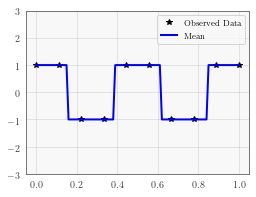

In [5]:
# Go into eval mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.fast_pred_var():
    # Test x are regularly spaced by 0.01 0,1 inclusive
    test_x = torch.linspace(0, 1, 101)
    # Get classification predictions
    observed_pred = likelihood(model(test_x))

    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Get the predicted labels (probabilites of belonging to the positive class)
    # Transform these probabilities to be 0/1 labels
    pred_labels = observed_pred.mean.ge(0.5).float().mul(2).sub(1)
    ax.plot(test_x.numpy(), pred_labels.numpy(), 'b')
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])